## Hyperspectral Data in Python

This module uses code and information from the [National Ecological Observation Network (NEON)](https://www.neonscience.org/resources/learning-hub/tutorials/neon-aop-hdf5-py). 

Hyperspectral remote sensing data is a powerful tool when doing remote sensing ecological analysis. Unlike traditional multispectral satellites such as Landsat or Sentinel-2 which have around 10 bands of spectral data, hyperspectral data contains hundreds of bands of spectral information. The NEON Airborn Observation Platform (AOP) collects 426 spectral bands when it images areas. NEON distributes this data in a `.h5` format, which we can use `h5py` to open and explore. For more information on this data product, refer to the <a href="http://data.neonscience.org/data-products/DP3.30006.001" target="_blank">NEON Data Product Catalog</a>.

With 426 bands, classification problems can become very granular and precise. For this module, we will open the hyperspetral data, explore it, then run an unsupervised KMeans classifier on the data to see how well we can classify it without any training data!

In [1]:
import warnings
import numpy as np
import h5py
import os
import earthpy as et
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import earthpy.plot as ep
from matplotlib.colors import ListedColormap
import rioxarray as rxr
from rasterio.plot import plotting_extent

%matplotlib inline
warnings.filterwarnings('ignore')

## Read in hdf5

```f = h5py.File('file.h5','r')``` reads in an `.h5` file to the variable f. From that variable, we can access all of the information stored in the `.h5` file. Much like GEDI data, this is hierarchical data, and we can explore the dataset using HDFViewer if we need to look at it outside of our script. 

In [2]:
# Download data from CyVerse
!wget https://data.cyverse.org/dav-anon/iplant/projects/earthlab/Macrosystems_workshop/NEON_AOP/NEON_D13_NIWO_DP3_452000_4432000_reflectance.h5

--2023-04-25 06:46:50--  https://data.cyverse.org/dav-anon/iplant/projects/earthlab/Macrosystems_workshop/NEON_AOP/NEON_D13_NIWO_DP3_452000_4432000_reflectance.h5
Resolving data.cyverse.org (data.cyverse.org)... 206.207.252.35
Connecting to data.cyverse.org (data.cyverse.org)|206.207.252.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 630365320 (601M) [application/octet-stream]
Saving to: ‘NEON_D13_NIWO_DP3_452000_4432000_reflectance.h5’

NEON_D13_NIWO_DP3_4 100%[===================>] 601.16M  56.8MB/s    in 10s     

2023-04-25 06:47:01 (57.7 MB/s) - ‘NEON_D13_NIWO_DP3_452000_4432000_reflectance.h5’ saved [630365320/630365320]



In [3]:
# Create a file path variable and read in the file with h5py.File
data_path = os.path.join("NEON_D13_NIWO_DP3_452000_4432000_reflectance.h5")
f = h5py.File(data_path, 'r')

## Explore NEON AOP HDF5 Reflectance Files

If we want to explore the dataset inside of Python, instead of in HDFViewer, we can look inside the HDF5 dataset with the ```h5py visititems``` function. The ```list_dataset``` function defined below displays all datasets stored in the hdf5 file and their locations within the hdf5 file:

In [4]:
# list_dataset lists the names of datasets in an hdf5 file
def list_dataset(name, node):
    if isinstance(node, h5py.Dataset):
        print(name)


f.visititems(list_dataset)

NIWO/Reflectance/Metadata/Ancillary_Imagery/Aerosol_Optical_Depth
NIWO/Reflectance/Metadata/Ancillary_Imagery/Aspect
NIWO/Reflectance/Metadata/Ancillary_Imagery/Cast_Shadow
NIWO/Reflectance/Metadata/Ancillary_Imagery/Dark_Dense_Vegetation_Classification
NIWO/Reflectance/Metadata/Ancillary_Imagery/Data_Selection_Index
NIWO/Reflectance/Metadata/Ancillary_Imagery/Haze_Cloud_Water_Map
NIWO/Reflectance/Metadata/Ancillary_Imagery/Illumination_Factor
NIWO/Reflectance/Metadata/Ancillary_Imagery/Path_Length
NIWO/Reflectance/Metadata/Ancillary_Imagery/Sky_View_Factor
NIWO/Reflectance/Metadata/Ancillary_Imagery/Slope
NIWO/Reflectance/Metadata/Ancillary_Imagery/Smooth_Surface_Elevation
NIWO/Reflectance/Metadata/Ancillary_Imagery/Visibility_Index_Map
NIWO/Reflectance/Metadata/Ancillary_Imagery/Water_Vapor_Column
NIWO/Reflectance/Metadata/Ancillary_Imagery/Weather_Quality_Indicator
NIWO/Reflectance/Metadata/Coordinate_System/Coordinate_System_String
NIWO/Reflectance/Metadata/Coordinate_System/EPSG C

You can see that there is a lot of information stored inside this reflectance hdf5 file. Most of this information is *metadata* (data about the reflectance data), for example, this file stores input parameters used in the atmospheric correction. You'll notice it's all stored under NIWO, which is the abbreviation NEON uses for their Niwot site. For this introductory lesson, we will only work with two of these datasets, the reflectance data (hyperspectral cube), and the corresponding geospatial information, stored in Metadata/Coordinate_System:

- `NIWO/Reflectance/Reflectance_Data`
- `NIWO/Reflectance/Metadata/Coordinate_System/`

We can also display the name, shape, and type of each of these datasets using the `ls_dataset` function defined below, which is also called with the `visititems` method: 

In [5]:
# ls_dataset displays the name, shape, and type of datasets in hdf5 file
def ls_dataset(name, node):
    if isinstance(node, h5py.Dataset):
        print(node)

In [6]:
f.visititems(ls_dataset)

<HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
<HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
<HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
<HDF5 dataset "Dark_Dense_Vegetation_Classification": shape (1000, 1000), type "|u1">
<HDF5 dataset "Data_Selection_Index": shape (1000, 1000), type "<i4">
<HDF5 dataset "Haze_Cloud_Water_Map": shape (1000, 1000), type "|u1">
<HDF5 dataset "Illumination_Factor": shape (1000, 1000), type "|u1">
<HDF5 dataset "Path_Length": shape (1000, 1000), type "<f4">
<HDF5 dataset "Sky_View_Factor": shape (1000, 1000), type "|u1">
<HDF5 dataset "Slope": shape (1000, 1000), type "<f4">
<HDF5 dataset "Smooth_Surface_Elevation": shape (1000, 1000), type "<f4">
<HDF5 dataset "Visibility_Index_Map": shape (1000, 1000), type "|u1">
<HDF5 dataset "Water_Vapor_Column": shape (1000, 1000), type "<f4">
<HDF5 dataset "Weather_Quality_Indicator": shape (1000, 1000, 3), type "|u1">
<HDF5 dataset "Coordinate_System_String": shap

Now that we can see the structure of the hdf5 file, let's take a look at some of the information that is stored inside. Let's start by extracting the reflectance data, which is nested under `NIWO/Reflectance/Reflectance_Data`:  

In [7]:
niwo_refl = f['NIWO']['Reflectance']
print(niwo_refl)

<HDF5 group "/NIWO/Reflectance" (2 members)>


The two members of the HDF5 group `/NIWO/Reflectance` are `Metadata` and `Reflectance_Data`. Let's save the reflectance data as the variable niwo_reflArray:

In [8]:
niwo_reflArray = niwo_refl['Reflectance_Data']
print(niwo_reflArray)

<HDF5 dataset "Reflectance_Data": shape (1000, 1000, 426), type "<i2">


We can extract the size of this reflectance array that we extracted using the `shape` method:

In [13]:
# Print shape of reflectance data
refl_shape = niwo_reflArray.shape
print('NIWO Reflectance Data Dimensions:', refl_shape)

NIWO Reflectance Data Dimensions: (1000, 1000, 426)


This 3-D shape (1000,1000,426) corresponds to (y,x,bands), where (x,y) are the dimensions of the reflectance array in pixels. Hyperspectral data sets are often called "cubes" to reflect this 3-dimensional shape.

<figure>
    <a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/DataCube.png">
    <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/DataCube.png"></a>
    <figcaption> A "cube" showing a hyperspectral data set. Source: National Ecological Observatory Network
    (NEON)  
    </figcaption>
</figure>


NEON hyperspectral data contain around 426 spectral bands, and when working with tiled data, the spatial dimensions are 1000 x 1000, where each pixel represents 1 meter. Now let's take a look at the wavelength values. First, we will extract wavelength information from the `niwo_refl` variable that we created:

In [14]:
# define the wavelengths variable
wavelengths = niwo_refl['Metadata']['Spectral_Data']['Wavelength']

# View wavelength information and values
print('wavelengths:', wavelengths)

wavelengths: <HDF5 dataset "Wavelength": shape (426,), type "<f4">


We can then use `numpy` (imported as `np`) to see the minimum and maximum wavelength values:

In [15]:
# Display min & max wavelengths
print('min wavelength:', np.amin(wavelengths), 'nm')
print('max wavelength:', np.amax(wavelengths), 'nm')

min wavelength: 381.598 nm
max wavelength: 2510.7485 nm


Finally, we can determine the band widths (distance between center bands of two adjacent bands). Let's try this for the first two bands and the last two bands. Remember that Python uses 0-based indexing (`[0]` represents the first value in an array), and note that you can also use negative numbers to splice values from the end of an array (`[-1]` represents the last value in an array).

In [16]:
# show the band widths between the first 2 bands and last 2 bands
print('band width between first 2 bands =',
      (wavelengths[1]-wavelengths[0]), 'nm')
print('band width between last 2 bands =',
      (wavelengths[-1]-wavelengths[-2]), 'nm')

band width between first 2 bands = 5.0097046 nm
band width between last 2 bands = 5.0095215 nm


The center wavelengths recorded in this hyperspectral cube range from `383.66 - 2511.94 nm`, and each band covers a range of ~`5 nm`. Now let's extract spatial information, which is stored under `NIWO/Reflectance/Metadata/Coordinate_System/Map_Info`:

In [17]:
niwo_mapInfo = niwo_refl['Metadata']['Coordinate_System']['Map_Info'].__array__(
).item()
print('NIWO Map Info:', niwo_mapInfo)

NIWO Map Info: b'UTM,  1.000,  1.000,       452000.00,       4433000.0,       1.0000000,       1.0000000,  13,  North,  WGS-84,  units=Meters, 0'


**Understanding the output:**

Here we can spatial information about the reflectance data. Below is a break down of what each of these values means:

- `UTM` - coordinate system (Universal Transverse Mercator)
- `1.000, 1.000` - 
- `368000.000, 4307000.0` - UTM coordinates (meters) of the map origin, which refers to the upper-left corner of the image  (xMin, yMax). 
- `1.0000000, 1.0000000` - pixel resolution (meters)
- `18` - UTM zone
- `N` - UTM hemisphere (North for all NEON sites)
- `WGS-84` - reference ellipoid

The letter `b` that appears before UTM signifies that the variable-length string data is stored in **b**inary format when it is written to the hdf5 file. We can remove that by putting `.decode('ascii')` on the end of our string to put it back into a more familiar format. For more information on hdf5 strings read the <a href="http://docs.h5py.org/en/latest/strings.html" target="_blank">h5py documentation</a>. 

Let's extract relevant information from the `Map_Info` metadata to define the spatial extent of this dataset. To do this, we can use the `split` method to break up this string into separate values:

In [18]:
# First convert mapInfo to a string
mapInfo_string = str(niwo_mapInfo.decode('ascii'))  # convert to string

In [20]:
# split the strings using the separator ","
mapInfo_split = mapInfo_string.split(",")
print(mapInfo_split)

['UTM', '  1.000', '  1.000', '       452000.00', '       4433000.0', '       1.0000000', '       1.0000000', '  13', '  North', '  WGS-84', '  units=Meters', ' 0']


Now we can extract the spatial information we need from the map info values, convert them to the appropriate data type (float) and store it in a way that will enable us to access and apply it later when we want to plot the data: 

In [21]:
# Extract the resolution & convert to floating decimal number
res = float(mapInfo_split[5]), float(mapInfo_split[6])
print('Resolution:', res)

Resolution: (1.0, 1.0)


In [22]:
# Extract the upper left-hand corner coordinates from mapInfo
xMin = float(mapInfo_split[3])
yMax = float(mapInfo_split[4])

# Calculate the xMax and yMin values from the dimensions
# xMax = left edge + (# of columns * x pixel resolution)

xMax = xMin + (refl_shape[1]*res[0])


# yMin = top edge - (# of rows * y pixel resolution)

yMin = yMax - (refl_shape[0]*res[1])

Now we can define the spatial exten as the tuple `(xMin, xMax, yMin, yMax)`. This is the format required for applying the spatial extent when plotting with `matplotlib.pyplot`.

In [23]:
# Define extent as a tuple:
niwo_ext = (xMin, xMax, yMin, yMax)
print('niwo_ext:', niwo_ext)
print('niwo_ext type:', type(niwo_ext))

niwo_ext: (452000.0, 453000.0, 4432000.0, 4433000.0)
niwo_ext type: <class 'tuple'>


## Extract a Single Band from Array

While it is useful to have all the data contained in a hyperspectral cube, it is difficult to visualize all this information at once. We can extract a single band (representing a ~5nm band, approximating a single wavelength) from the cube by using splicing as follows. Note that we have to cast the reflectance data into the type `float`. Recall that since Python indexing starts at 0 instead of 1, in order to extract band 56, we need to use the index 55.

In [24]:
b56 = niwo_reflArray[:, :, 55].astype(float)
print('b56 type:', type(b56))
print('b56 shape:', b56.shape)
print('Band 56 Reflectance:\n', b56)

b56 type: <class 'numpy.ndarray'>
b56 shape: (1000, 1000)
Band 56 Reflectance:
 [[445. 600. 668. ... 152. 168. 251.]
 [535. 639. 729. ... 178. 242. 234.]
 [350. 413. 369. ...  29.  60. 144.]
 ...
 [355. 557. 695. ... 223. 272. 314.]
 [290. 540. 522. ... 367. 331. 543.]
 [105.  53.  71. ... 446. 611. 554.]]


Here we can see that we extracted a 2-D array (1000 x 1000) of the scaled reflectance data corresponding to the wavelength band 56. Before we can use the data, we need to clean it up a little. We'll show how to do this below. 

##  Scale factor and No Data Value

This array represents the scaled reflectance for band 56, which is within the range of red visible light. You can explore the HDF5 data in HDFViewer and find that NEON AOP reflectance data uses a `Data_Ignore_Value` of `-9999` to represent missing data (often called `NaN`), and a reflectance `Scale_Factor` of `10000.0` in order to save disk space (can use lower precision this way). 

We can extract and apply the `Data_Ignore_Value` and `Scale_Factor` as follows:

In [25]:
# View and apply scale factor and data ignore value
scaleFactor = niwo_reflArray.attrs['Scale_Factor']
noDataValue = niwo_reflArray.attrs['Data_Ignore_Value']
print('Scale Factor:', scaleFactor)
print('Data Ignore Value:', noDataValue)

b56[b56 == int(noDataValue)] = np.nan
b56 = b56/scaleFactor
print('Cleaned Band 56 Reflectance:\n', b56)

Scale Factor: 10000.0
Data Ignore Value: -9999.0
Cleaned Band 56 Reflectance:
 [[0.0445 0.06   0.0668 ... 0.0152 0.0168 0.0251]
 [0.0535 0.0639 0.0729 ... 0.0178 0.0242 0.0234]
 [0.035  0.0413 0.0369 ... 0.0029 0.006  0.0144]
 ...
 [0.0355 0.0557 0.0695 ... 0.0223 0.0272 0.0314]
 [0.029  0.054  0.0522 ... 0.0367 0.0331 0.0543]
 [0.0105 0.0053 0.0071 ... 0.0446 0.0611 0.0554]]


## Plot single reflectance band

Now we can plot this band using the Python package ```earthpy.plot```, which we imported at the beginning of the lesson as ```ep```. We can use `plot_bands` to plot a single band.

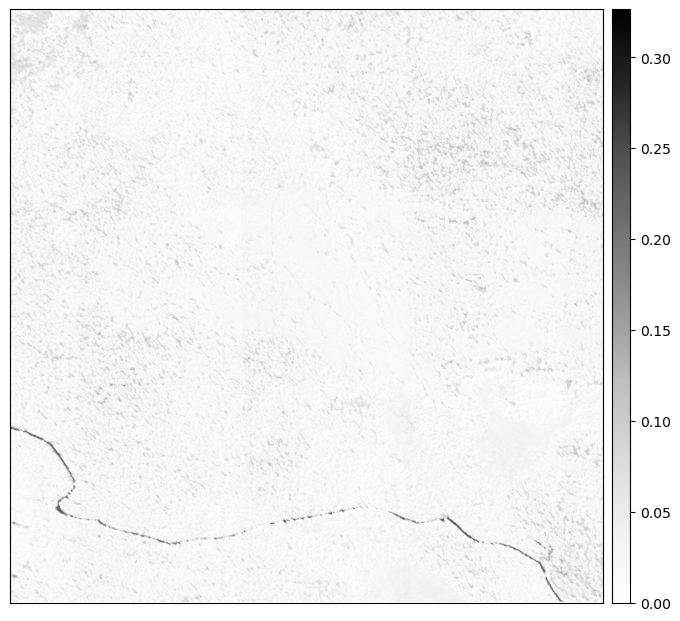

In [26]:
# Plot bands with plot_bands function
ep.plot_bands(b56,
              extent=niwo_ext,
              cmap='Greys',
              figsize=(8, 8))
plt.show()

We can see that this image looks pretty washed out. To see why this is, it helps to look at the range and distribution of reflectance values that we are plotting. We can do this by making a histogram. 

## Plot histogram

We can plot a histogram using the `earthpy.plot.hist` function. Note that this function won't work if there are any NaN values, so we can ensure we are only plotting the real data values using the call below. You can also specify the # of bins you want to divide the data into. 

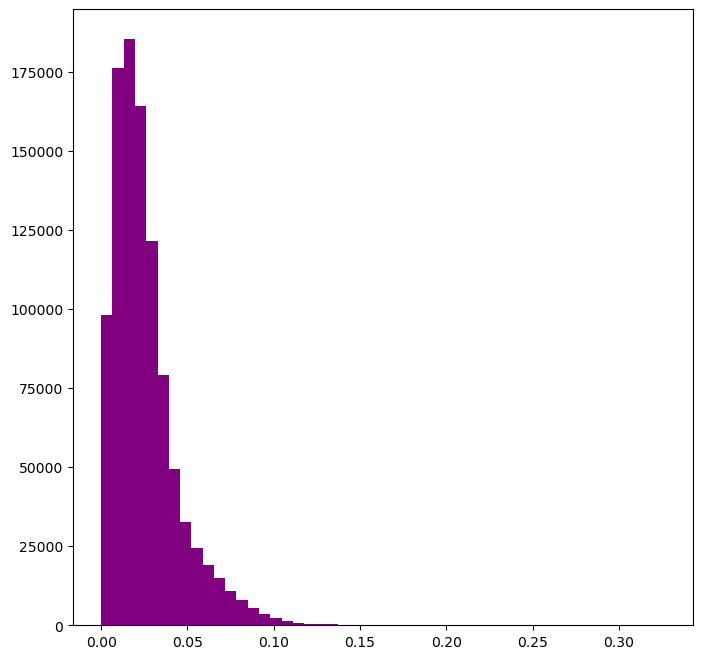

In [27]:
# Plot histogram
ep.hist(b56,
        bins=50,
        figsize=(8, 8))
plt.show()

We can see that most of the reflectance values are < 0.2. In order to show more contrast in the image, we can adjust the `vmax` argument in `ep.plot_bands` to 0.2 to cut off all values over that:

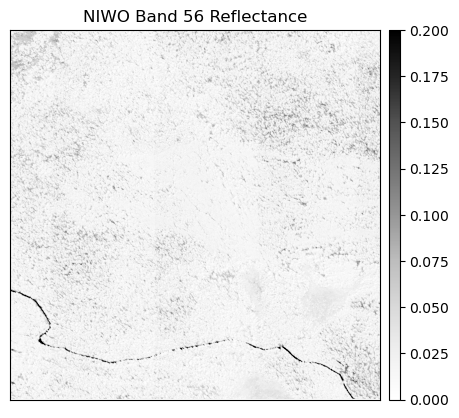

In [28]:
# Plot band 56 with vmax
fig, ax = plt.subplots()
ep.plot_bands(b56,
              extent=niwo_ext,
              cmap='Greys',
              vmax=.2,
              ax=ax,
              title='NIWO Band 56 Reflectance')
plt.show()

# Plot RGB

When using hyperspectral data, and comparing it to a classification attempt, a true color image may be helpful to have. Let's look at all of the wavelength values we have and pick some to represent red, blue, and green so we can plot in true color. To see this, we can loop through the values and display their index using `enumerate`. 

In [29]:
# Print list of wavelengths
for index, wave in enumerate(wavelengths):
    if wave > 450 and wave < 515:
        print("Blue Wavelength {0} at index {1}".format(wave, index))
    elif wave > 525 and wave < 600:
        print("Green Wavelength {0} at index {1}".format(wave, index))
    elif wave > 630 and wave < 680:
        print("Red Wavelength {0} at index {1}".format(wave, index))

Blue Wavelength 451.7347106933594 at index 14
Blue Wavelength 456.744384765625 at index 15
Blue Wavelength 461.75421142578125 at index 16
Blue Wavelength 466.7640075683594 at index 17
Blue Wavelength 471.7737121582031 at index 18
Blue Wavelength 476.78350830078125 at index 19
Blue Wavelength 481.7933044433594 at index 20
Blue Wavelength 486.8030090332031 at index 21
Blue Wavelength 491.81280517578125 at index 22
Blue Wavelength 496.8226013183594 at index 23
Blue Wavelength 501.8323059082031 at index 24
Blue Wavelength 506.84210205078125 at index 25
Blue Wavelength 511.8518981933594 at index 26
Green Wavelength 526.8812255859375 at index 29
Green Wavelength 531.8909301757812 at index 30
Green Wavelength 536.9006958007812 at index 31
Green Wavelength 541.9105224609375 at index 32
Green Wavelength 546.9202270507812 at index 33
Green Wavelength 551.9299926757812 at index 34
Green Wavelength 556.9398193359375 at index 35
Green Wavelength 561.9495239257812 at index 36
Green Wavelength 566.95

Looking at these values, there are multiple wavelengths we could use for each color because of how high the spectral resolution of the imagery is! For this exercise, let's use `476.78350830078125` for blue at index `20`, `566.9592895507812` for green at index `37`, and the `b56` variable we created earlier for red. We can then combine them all into a single array and plot it with another `earthpy.plot` function, `plot_rgb`. 

In [31]:
# Create blue and green bands, then combine with band 56 into one rgb array
blue_band = niwo_reflArray[:, :, 20].astype(float)
blue_band[blue_band == int(noDataValue)] = np.nan
blue_band = blue_band/scaleFactor

green_band = niwo_reflArray[:, :, 37].astype(float)
green_band[green_band == int(noDataValue)] = np.nan
green_band = green_band/scaleFactor

red_band = b56

# Put all bands in an array together
rgb = np.array([red_band, green_band, blue_band])



# Confirm we have an array of the shape we expect
rgb.shape

(3, 1000, 1000)

Plotting the data, you can see it is rather dim much like the single band data when plotted without modifying the range of values. For rgb plotting, we can simply set the `stretch` argument in `ep.plot_rgb` to `True`. This should brighten up the image and make it easier to view. 

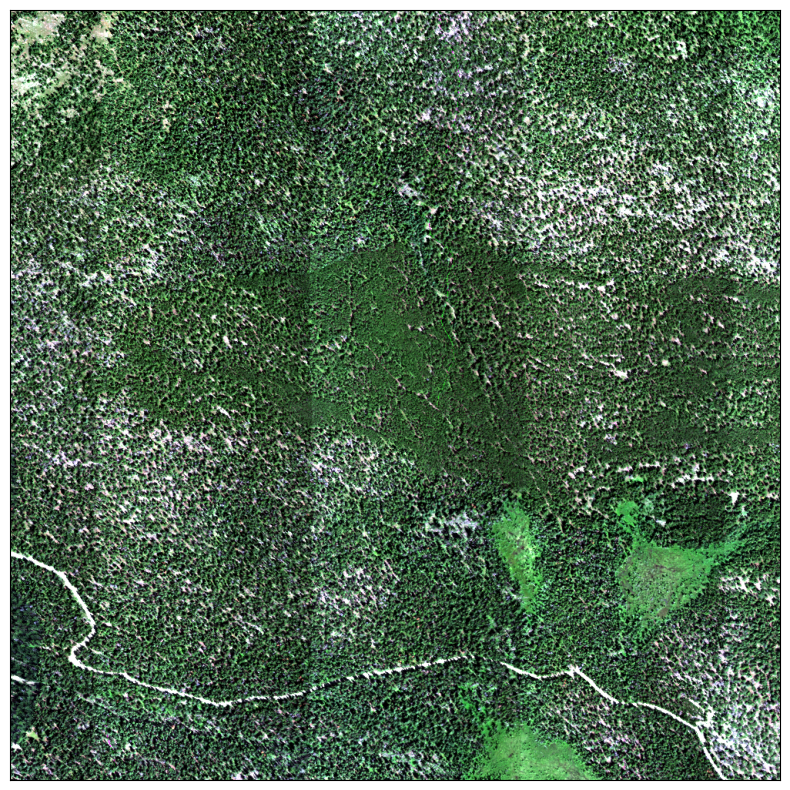

In [32]:
# Plot rgb data
ep.plot_rgb(rgb, stretch=True)

plt.show()

## Classify the Data

To classify the data, in order to use a machine learning algorithm such as Random Forest, we would need labeled data. We do not have that for this image, but we can still classify this with a clustering algorithm! While this is not machine learning, the work flow and set up is very similar to what we would do if we were using Random Forest. We will use [sklearn's K-Means clustering algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). This finds a number of groups (`k`) that are most closely clustered within the array based on their spectral values. [Towards machine learning has a great quick explanation on how this algorithm works](https://towardsmachinelearning.org/k-means/).

<figure>
    <a href="https://lh5.googleusercontent.com/EqtP_WelBGJ7s_LFx6qaOX4OF0hOubZBWphtEyeDbqweV-Tw2hyfXzmPN9vhSEACihWmKlReI_eInUxbGg4tQmWeKjrC4yTicGfkMfaWgFszvrrfCRPPsSj6WD-Ok8eUQHaBpqNzuszS40R6ww">
    <img src="https://lh5.googleusercontent.com/EqtP_WelBGJ7s_LFx6qaOX4OF0hOubZBWphtEyeDbqweV-Tw2hyfXzmPN9vhSEACihWmKlReI_eInUxbGg4tQmWeKjrC4yTicGfkMfaWgFszvrrfCRPPsSj6WD-Ok8eUQHaBpqNzuszS40R6ww"></a>
    <figcaption> A demonstration of how K-Means clustering works in 2-D space Source: Towards Machine Learning 
    </figcaption>
</figure>



The hope is that we will be able to get general groups such as bare ground, trees, and shrubs. This can be a useful start when creating labeled data for supervised learning, or a quick and easy way to get a general idea of how 
objects are distributed in your study area. 

### Preparing the Data

To run this, we will need to modify the shape of our array to be something that `KMeans` can use. . We will get the reflectance array from the `niwo_reflArray` object using `.__array__()`. We can then create our new shape and use `numpy`'s reshape function to get our desired shape. 

In [ ]:
# Current array shape: (1000, 1000, 426)
data_arr = niwo_reflArray.__array__()

# Desired shape: (1000000, 426)
data_arr_flat = (data_arr.shape[0] * data_arr.shape[1],
                 data_arr.shape[2])

# Creating and array with shape (1000000, 426)
img_as_array = data_arr[:, :, :426].reshape(data_arr_flat)

### Run the classification

We can run the classification fairly easily below! This code will take a while to run because our array is large, expect a few minutes of processing time when running the chunk below. We create a KMeans model with `KMeans` and specify how many groupings we want with `n_clusters`. For this image, 3 seems to be a good number to capture the trees, shrubs, and bare ground. We then apply that model to our data with `fit_predict`. 

In [ ]:
# Run model with 3 clusters on our reshaped data
prediction = KMeans(n_clusters=3).fit_predict(img_as_array)

We classified our image! however, the image is still in the shape `(1000000, 426)`, which is not helpful to us! We need to reshape it again, and combining be difficult. We can use a combination of `np.rot90` and `np.fliplr` to orient our data back to it's original orientation once we put it back into the original shape of `1000, 1000, 426)` using `.reshape`. 

In [ ]:
# Check the shape of the output of the prediction
prediction.shape

In [ ]:
# Recreate our original image
prediction_reshape = np.rot90(
    np.fliplr(prediction.reshape(data_arr[:, :, 0].shape)))

Since this is an unsupervised classification, we won't know how the groupings are chosen. We will label our groups with generic names, and then assign a custom colormap with three values that we can create with `ListedColormap`. For more information on using custom colormaps and legends, you can view [the lesson on classifying dNBR data](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/calculate-dNBR-Landsat-8/) on [earthdatascience.org](https://www.earthdatascience.org/).

In [ ]:
# Creating the group names
cat_names = ["Group 1", "Group 2", "Group 3"]

# Choosing the colors for the classification
colors = ["darkgreen",
          "lime",
          "white"]

# Turning our chosen colors into a colormap
custom_cmap = ListedColormap(colors)

In [ ]:
f, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 12))

# Plot RGB Data on one axes using plot_rgb
ep.plot_rgb(rgb, ax=ax, extent=niwo_ext, stretch=True,
            title="True Color Hyperspectral Image")

# Plot classified data on seperate axes with imshow
im = ax2.imshow(prediction_reshape.transpose([1, 0]),
                cmap=custom_cmap,
                extent=niwo_ext,
                interpolation='none')

# Turn off x/y values on sides of image
ax2.set(xticks=[], yticks=[])

# Get classes from image to put on our legend
classes = np.unique(prediction_reshape)
classes = classes.tolist()[:5]

# Create legend with our group names
ep.draw_legend(im_ax=im,
               titles=cat_names,
               classes=classes)

ax2.set_title("Final Classified Image")

plt.show()

## Drone Data

Now that we've classified the hyperspectral data, we can compare it to drone data collected at the same site to see similarities and differences! Drone data is not hyperspectral, but it is multispectral, so the work flow is similar to how we classified our hyperspectral data, just with less bands. Our drone data is a `.tif`, so we can open it with `rioxarray.open_rasterio` like we did with the ECOSTRESS data. 

In [ ]:
# Open the drone data, mask out null values
drone_data = rxr.open_rasterio(os.path.join(
    data_path, "M300-NIWOT-Plot2-6-23-22-ortho-clipped.tif"), masked=True)

We can get the `numpy` array from the `xarray` object using `.values`. We need the `numpy` array to put the data into a `KMeans` classifier. Additionally, the drone data has 10 bands of data, but there are 11 bands in our `xarray` object. This is due to the fact that the drone data has an `alpha` band we don't need. We can drop it by indexing the array to only include the first 10 bands. 

In [ ]:
# The drone data has a band we don't need, so we can clip it to just the first 10 bands with [:10]
# We get the numpy array out of the xarray object using .values
drone_data_arr = drone_data.values[:10]

# View the new shape to confirm we only have the 10 bands we want
drone_data_arr.shape

Let's see the data! The `rgb` bands for the drone are stored at the 1st, 3rd, and 5th index. We can tell `plot_rgb` which bands we want to use to visualize the data with the `rgb=` parameter. 

In [ ]:
# Plot rgb drone data


Now that our drone data is in a `numpy` array, we can reshape it like we did with our hyperspectral data! You'll notice a difference where the number of bands is first in the shape of this data, instead of last like it was for our hyperspectral data. We can change it to be the same as our hyperspectral using `transpose` from `numpy`. 

In [ ]:
# Changing shape from (10, 2441, 2115) to (2441, 2115, 10)
drone_reshape = drone_data_arr.transpose([2, 1, 0])

# Creating shape (5162715, 10)


# Creating array of shape (5162715, 10)


Now that our array is in the desired shape, we can run it through `KMeans` the same way we did earlier!

In [ ]:
# Create KMeans model with 3 clusters and fit to drone data


Now that we have our prediction, we can reshape it to the original shape. 

In [ ]:
# Reshape data to original shape
drone_prediction_reshape = drone_prediction.reshape(
    drone_reshape[:, :, 0].shape)

## Plotting all our data together

Let's compare our drone and hyperspectral classifications! To do this, we'll need to create a drone extent object, and get the spatial bounds of our drone data so we can zoom into the part of our hyperspectral data that matches our drone data. To get the spatial bounds, we can use `.rio.bounds()`, and to create the extent we can use the `rasterio` function `plotting_extent`, like we did with ECOSTRESS data. 

In [ ]:
# Create drone extent and get the bounds for the drone data
drone_bounds = drone_data.rio.bounds()
drone_extent = plotting_extent(drone_data[0], drone_data.rio.transform())
drone_bounds

This is a complicated plot! We create 4 axes, loop through the axes and set the bounds to match the drone data extent, and then plot each data we want onto each of the axes we created. 

In [ ]:
# Plot all the data together!
f, axes = plt.subplots(2, 2, figsize=(9, 9))

ax, ax2, ax3, ax4 = axes[0][0], axes[0][1], axes[1][0], axes[1][1],

for group in axes:
    for a in group:
        a.set(ylim=[drone_bounds[1], drone_bounds[3]],
              xlim=[drone_bounds[2], drone_bounds[0]],
              xticks=[],
              yticks=[])

ep.plot_rgb(rgb,
            ax=ax,
            extent=niwo_ext,
            stretch=True,
            title="Hyperspectal True Color")

im = ax2.imshow(prediction_reshape.transpose([1, 0]),
                cmap=custom_cmap,
                extent=niwo_ext,
                interpolation='none')

ax2.set_title("Hyperspectral KMeans Classification")

ep.draw_legend(im_ax=im,
               titles=cat_names,
               classes=classes)


ep.plot_rgb(drone_data_arr,
            rgb=[5, 3, 1],
            stretch=True,
            ax=ax3,
            extent=drone_extent,
            title="Drone Imagery True Color")


im3 = ax4.imshow(drone_prediction_reshape.transpose([1, 0]),
                 cmap=custom_cmap,
                 extent=drone_extent,
                 interpolation='none')

ax4.set_title("Drone Imagery KMeans Classification")


ep.draw_legend(im_ax=im3,
               titles=cat_names,
               classes=classes)

plt.show()